# ML Pipeline

In [1]:
import geoengine as ge

from geoengine_openapi_client.models import MlModelMetadata, RasterDataType

from sklearn.tree import DecisionTreeClassifier
import numpy as np
from skl2onnx import to_onnx


In [2]:
ge.initialize("http://localhost:3030/api")

## Train a dummy model (TODO: feed with data from Geo Engine)

In [3]:
np.random.seed(0) 
X = np.random.rand(100, 2).astype(np.float32)  # 100 instances, 2 features
y = np.where(X[:, 0] > X[:, 1], 42, 33)  # 1 if feature 0 > feature 42, else 33

clf = DecisionTreeClassifier()
clf.fit(X, y)

test_samples = np.array([[0.1, 0.2], [0.2, 0.1]])
predictions = clf.predict(test_samples)
print("Predictions:", predictions)

# Convert into ONNX format.
from skl2onnx import to_onnx

onx = to_onnx(clf, X[:1], target_opset=9) # target_opset is the ONNX version to use

Predictions: [33 42]


## Register it with Geo Engine

In [4]:
model_name = f"{ge.get_session().user_id}:decision_tree"

metadata = MlModelMetadata(
    file_name="model.onnx",
    input_type=RasterDataType.F32,
    num_input_bands=2,
    output_type=RasterDataType.I64,
)

ge.register_ml_model(onnx_model=onx, name=model_name, metadata=metadata, display_name="Decision Tree", description="A simple decision tree model")

# Apply model using the ONNX operator

{'type': 'Raster', 'operator': {'type': 'RasterTypeConversion', 'params': {'outputDataType': 'U8'}, 'sources': {'raster': {'type': 'Onnx', 'params': {'model': '314d564b-8d92-404c-8ef9-3ecaa7415751:decision_tree'}, 'sources': {'raster': {'type': 'BandwiseExpression', 'params': {'expression': 'x/255', 'outputType': 'F32', 'mapNoData': False}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'default'}}, 'sources': {'rasters': [{'type': 'GdalSource', 'params': {'data': 'ndvi'}}, {'type': 'TimeShift', 'params': {'type': 'relative', 'granularity': 'months', 'value': -1}, 'sources': {'source': {'type': 'GdalSource', 'params': {'data': 'ndvi'}}}}]}}}}}}}}}


/home/michael/git/geoengine-python/env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


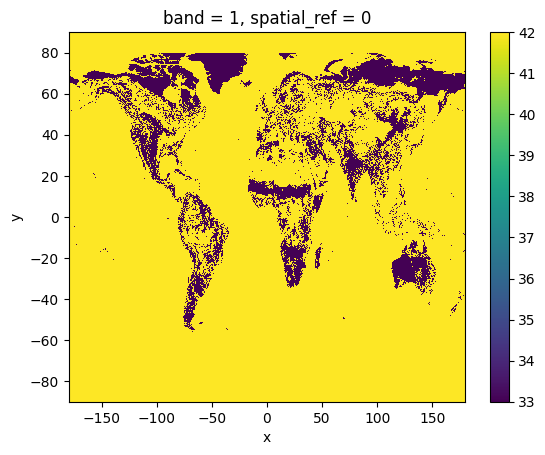

In [6]:
# create raster with two bands, one ndvi of current month and one ndvi of the previous month
bands = [ge.workflow_builder.operators.GdalSource("ndvi"),
         ge.workflow_builder.operators.TimeShift(source=ge.workflow_builder.operators.GdalSource("ndvi"), 
                                                 shift_type="relative", 
                                                 granularity="months", 
                                                 value=-1)]
stack = ge.workflow_builder.operators.RasterStacker(sources = bands)

# normalize the input to 0-1 and convert to float32
normalized = ge.workflow_builder.operators.BandwiseExpression(expression="x/255", source=stack, output_type="F32")

# use the registered ml model for prediction
onnx = ge.workflow_builder.operators.Onnx(source=normalized, model=model_name)

# convert the predictions to U8 because ONNX outputs I64 which our Gdal version output currently
converted_output = ge.workflow_builder.operators.RasterTypeConversion(source=onnx, output_data_type="U8")

workflow_dict = converted_output.to_workflow_dict()

workflow = ge.register_workflow(workflow_dict)

query = ge.QueryRectangle(
    ge.BoundingBox2D(-180, -90, 180, 90),
    ge.TimeInterval(np.datetime64('2014-04-01')),
    ge.SpatialResolution(0.1, 0.1)
)

data = workflow.get_xarray(
    query
)

data.plot()